In [0]:
import gzip
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Data Preparation

In [2]:
# http://yann.lecun.com/exdb/mnist/
!curl -OL http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -OL http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -OL http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -OL http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  34.7M      0 --:--:-- --:--:-- --:--:-- 34.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0  67795      0 --:--:-- --:--:-- --:--:-- 67795
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  7559k      0 --:--:-- --:--:-- --:--:-- 7559k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  54071      0 --:--:-- --:--:-- --:--:-- 53435


In [0]:
def get_data(fn):
  with gzip.open(fn, 'r') as f:
    magic = int.from_bytes(f.read(4), byteorder='big')
    n_images = int.from_bytes(f.read(4), byteorder='big')
    n_rows = int.from_bytes(f.read(4), byteorder='big')
    n_cols = int.from_bytes(f.read(4), byteorder='big')

    assert magic == 2051
    assert n_rows == n_cols

    image_size = n_rows

    buf = f.read(image_size * image_size * n_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(n_images, image_size, image_size, 1)

  return data

In [0]:
def get_labels(fn):
  with gzip.open(fn, 'r') as f:
    magic = int.from_bytes(f.read(4), byteorder='big')
    n_labels = int.from_bytes(f.read(4), byteorder='big')

    assert magic == 2049

    buf = f.read(n_labels)
    labels = np.frombuffer(buf, dtype=np.uint8)

  return tf.keras.utils.to_categorical(labels)

In [0]:
X_train = get_data('train-images-idx3-ubyte.gz')
y_train = get_labels('train-labels-idx1-ubyte.gz')
X_test = get_data('t10k-images-idx3-ubyte.gz')
y_test = get_labels('t10k-labels-idx1-ubyte.gz')

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [10]:
print('Training', X_train.shape, y_train.shape)
print('Validation', X_valid.shape, y_valid.shape)
print('Testing', X_test.shape, y_test.shape)

Training (48000, 28, 28, 1) (48000, 10)
Validation (12000, 28, 28, 1) (12000, 10)
Testing (10000, 28, 28, 1) (10000, 10)


In [11]:
X_train[2,10:15,10:15,0]

array([[184., 109., 120., 194., 254.],
       [232., 224., 213., 102.,  58.],
       [ 14.,   4.,  34., 114., 200.],
       [156., 210., 254., 211., 132.],
       [222., 138.,  46.,   9.,   0.]], dtype=float32)

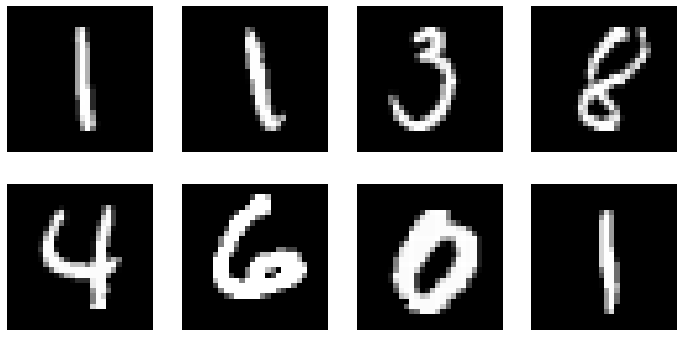

In [12]:
fig, axes = plt.subplots(2,4, figsize=(12,6))
for i in range(2):
  for j in range(4):
    k = np.random.randint(X_train.shape[0])
    image = np.asarray(X_train[k]).squeeze()
    axes[i,j].imshow(image, cmap='gray')
    axes[i,j].axis('off')
plt.show()

# Model Definition

- https://medium.com/@sh.tsang/paper-brief-review-of-lenet-1-lenet-4-lenet-5-boosted-lenet-4-image-classification-1f5f809dbf17

In [0]:
def lenet1(in_shape, n_classes):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(filters=4, kernel_size=5, input_shape=in_shape, activation='tanh'))
  model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Conv2D(filters=8, kernel_size=5, activation='tanh'))
  model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
  return model

In [0]:
def lenet5(in_shape, n_classes):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=5, input_shape=in_shape, activation='tanh'))
  model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='tanh'))
  model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(120, activation='tanh'))
  model.add(tf.keras.layers.Dense(84, activation='tanh'))
  model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
  return model

In [17]:
n_classes = 10
in_shape = (28,28,1) # channels last
model = lenet5(in_shape, n_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [0]:
model.compile(optimizer='sgd', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training

In [0]:
batch_size = 32
epochs = 100

In [0]:
# See https://keras.io/preprocessing/image/
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [0]:
X_valid = (X_valid - datagen.mean[0]) / datagen.std[0]
Xtest = (X_test - datagen.mean[0]) / datagen.std[0]

In [0]:
Xtest = (X_test - datagen.mean[0]) / datagen.std[0]

In [24]:
# fits the model on batches with real-time data augmentation:

generator = datagen.flow(X_train, y_train, batch_size=batch_size)
history = model.fit_generator(generator,
                              steps_per_epoch=len(X_train) / batch_size, 
                              validation_data=(X_valid,y_valid),
                              epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
1500/1500 [==============================] - 33s 22ms/step - loss: 1.8087 - accuracy: 0.3524 - val_loss: 1.1275 - val_accuracy: 0.6420
Epoch 2/100
1500/1500 [==============================] - 34s 23ms/step - loss: 1.1255 - accuracy: 0.6281 - val_loss: 0.7274 - val_accuracy: 0.7781
Epoch 3/100
1500/1500 [==============================] - 33s 22ms/step - loss: 0.8194 - accuracy: 0.7336 - val_loss: 0.5113 - val_accuracy: 0.8528
Epoch 4/100
1500/1500 [==============================] - 33s 22ms/step - loss: 0.6857 - accuracy: 0.7749 - val_loss: 0.4161 - val_accuracy: 0.8732
Epoch 5/100
1500/1500 [==============================] - 34s 22ms/step - loss: 0.5939 - accuracy: 0.8081 - val_loss: 0.4020 - val_accuracy: 0.8733
Epoch 6/100
1500/1500 [==============================] - 34s 23ms/step - loss: 0.5359 - accuracy: 0.8239 - val_loss: 0.3376 - val_accuracy: 0.8961
Epoch 7/100
1500/1500 [===================

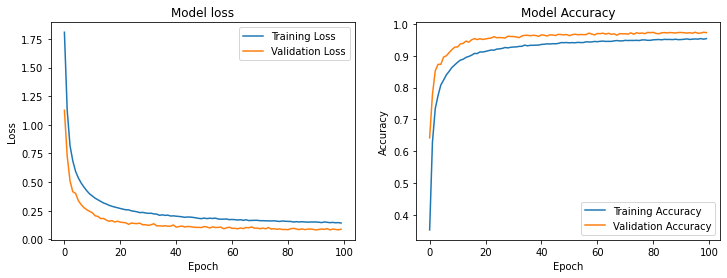

In [27]:
fix, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(loc='upper right')
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='lower right')
plt.show()

# Evaluation

In [28]:
loss, accuracy = model.evaluate(Xtest, y_test)
print('Accuracy is: %.2f%%' % (accuracy*100))

313/313 [==============================] - 2s 7ms/step - loss: 0.0852 - accuracy: 0.9731
Accuracy is: 97.31%


In [29]:
predictions = model.predict(Xtest) # (N,n_classes)
pred_labels = predictions.argmax(axis=1) # (N,)

_, true_labels = np.nonzero(y_test)
accuracy = 100 * (pred_labels == true_labels).sum() / pred_labels.size
print('Accuracy is: %.2f%%' % accuracy)

Accuracy is: 97.31%


In [30]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.94      0.94      0.94      1032
           3       0.99      0.95      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.90      0.98      0.94       892
           6       0.98      0.97      0.97       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# Feature Visualization

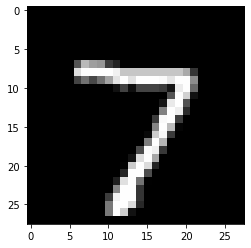

In [31]:
input_image = X_test[0]
plt.imshow(input_image.squeeze(), cmap='gray')
plt.show()

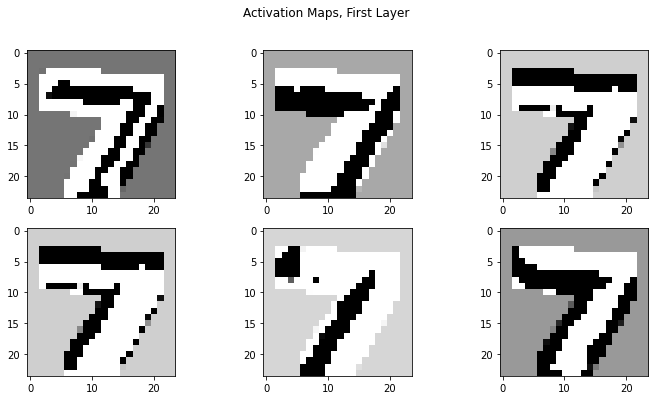

In [34]:
in_img = tf.constant(input_image[np.newaxis,...])
conv1 = model.layers[0]
tf_out = conv1(in_img)
out1 = tf_out.numpy().squeeze()

fig, axes = plt.subplots(2,3, figsize=(12,6))
for i in range(2):
  for j in range(3):
    k = i * 2 + j
    axes[i,j].imshow(out1[...,k], cmap='gray')
    #axes[i,j].axis('off')
fig.suptitle('Activation Maps, First Layer')
plt.show()

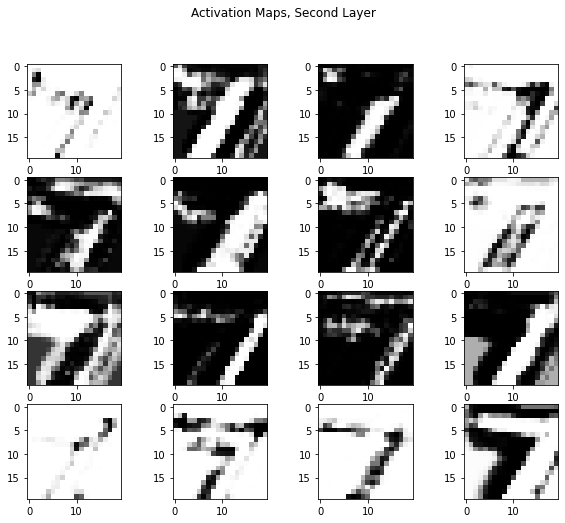

In [35]:
conv2 = model.layers[2]
out2 = conv2(tf_out).numpy().squeeze()
fig, axes = plt.subplots(4,4, figsize=(10,8))
for i in range(4):
  for j in range(4):
    k = i * 4 + j
    axes[i,j].imshow(out2[...,k], cmap='gray')
    #axes[i,j].axis('off')
fig.suptitle('Activation Maps, Second Layer')
plt.show()